In [0]:
# colab setting
!pip install GraphRicciCurvature

import networkx as nx
import numpy as np
import math
import importlib
from IPython.display import clear_output

# matplotlib setting
%matplotlib inline
import matplotlib.pyplot as plt

# to print logs in jupyter notebook
import logging
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.ERROR)

# load GraphRicciCuravture package
from GraphRicciCurvature.OllivierRicci import OllivierRicci
clear_output()

In [0]:
!pip install torch-scatter==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.5.0.html
!pip install torch-sparse==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.5.0.html
!pip install torch-cluster==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.5.0.html
!pip install torch-spline-conv==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.5.0.html
!pip install torch-geometric
clear_output()

# CurvConv architecture

In [0]:
import torch
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch.nn import Sequential as seq, Parameter,LeakyReLU,init,Linear
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import softmax,degree, add_self_loops, remove_self_loops
from torch_geometric.nn import GCNConv, EdgeConv, ECConv
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [0]:
class  curvGN(MessagePassing):
    def __init__(self, in_channels, out_channels, w_mul, bias=True):
        super(curvGN, self).__init__(aggr='add') # "Add" aggregation.
        self.w_mul = w_mul
        self.lin = Linear(in_channels, out_channels)
        widths = [1, out_channels]
        self.w_mlp_out = create_wmlp(widths, out_channels, True)

    def forward(self, x, edge_index):
        x = self.lin(x)
        out_weight = self.w_mlp_out(self.w_mul)
        out_weight = softmax(out_weight, edge_index[0])
        return self.propagate(x=x,
                              edge_index=edge_index,
                              out_weight=out_weight)

    def message(self,x_j, edge_index, out_weight):
        return out_weight*x_j

    def update(self, aggr_out):
        # aggr_out has shape [N, out_channels]
        # Step 5: Return new node embeddings.
        return aggr_out

def create_wmlp(widths, nfeato, lbias):
    mlp_modules=[]
    for k in range(len(widths)-1):
        mlp_modules.append(Linear(widths[k], widths[k+1], bias=False))
        mlp_modules.append(LeakyReLU(0.2, True))
    mlp_modules.append(Linear(widths[len(widths)-1], nfeato, bias=lbias))

    return seq(*mlp_modules)


In [0]:
class NetСurv(torch.nn.Module):
    def __init__(self, num_features, num_classes, w_mul, hidden=64):
        '''
        w_mul - curvatures
        '''
        super(NetСurv, self).__init__()

        self.conv1 = curvGN(num_features, hidden, hidden, w_mul=w_mul)
        self.conv2 = curvGN(hidden, num_classes, num_classes, w_mul=w_mul)

    def forward(self,data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x,training=self.training)
        x = self.conv2(x, edge_index)
        
        return F.log_softmax(x, dim=1)

class Net(torch.nn.Module):
    def __init__(self, num_features, num_classes, hidden=64):
        super(Net, self).__init__()
        self.conv1 = GCNConv(num_features, 16)
        self.conv2 = GCNConv(16, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)
    

# Dataset

In [6]:
from torch_geometric.datasets import Planetoid
from torch_geometric.utils.convert import from_networkx, to_networkx
dataset = Planetoid( root='/tmp/Cora', name='Cora')

Processing...
Done!


In [0]:
data =  
data_nx = to_networkx(data)
orc = OllivierRicci(data_nx, alpha=0.5, verbose="INFO")
_ = orc.compute_ricci_curvature()
G_orc = orc.G.copy()
ricci_curvatures = nx.get_edge_attributes(G_orc, "ricciCurvature")

INFO:Number of nodes: 2708
INFO:Number of edges: 10556
INFO:Start to compute all pair shortest path.


Edge weight not detected in graph, use "weight" as default edge weight.


INFO:1.063510 secs for all pair by NetworKit.
INFO:76.499043 secs for Ricci curvature computation.


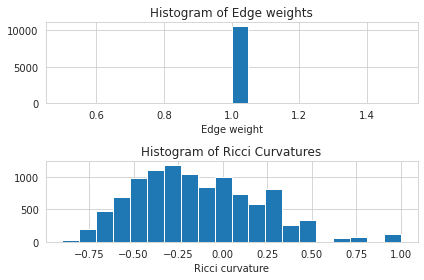

In [0]:
def show_results(G):

    # Plot the histogram of Ricci curvatures
    plt.subplot(2, 1, 2)
    ricci_curvtures = nx.get_edge_attributes(G, "ricciCurvature").values()
    plt.hist(ricci_curvtures,bins=20)
    plt.xlabel('Ricci curvature')
    plt.title("Histogram of Ricci Curvatures")

    # Plot the histogram of edge weights
    plt.subplot(2, 1, 1)
    weights = nx.get_edge_attributes(G, "weight").values()
    plt.hist(weights,bins=20)
    plt.xlabel('Edge weight')
    plt.title("Histogram of Edge weights")

    plt.tight_layout()
    
show_results(G_orc)

In [0]:
data_0_nx_ric = nx.get_edge_attributes()

In [0]:
data_0_ric = from_networkx(data_0_nx_ric)

# Training

In [0]:
model = Net().to(device)
data = dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

loss_history = []
model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data) # data leak?
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    loss_history.append(loss.item())

model.eval()
_, pred = model(data).max(dim=1)
correct = float (pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
acc = correct / data.test_mask.sum().item()
print('Accuracy: {:.4f}'.format(acc))

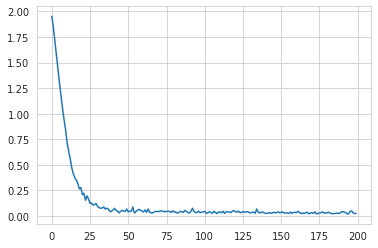

In [0]:
plt.plot(loss_history)